In [168]:
#-----General------#
import numpy as np
import pandas as pd
import math
import random

#-----Plotting-----#
import matplotlib.pyplot as plt
import seaborn as sns

#-----Utility-----#
import itertools
import warnings
warnings.filterwarnings("ignore")
from datetime import date, datetime
import json
import requests
import statsmodels.api as sm


In [169]:
colUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=COL&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(colUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

colDf = pd.DataFrame(json_data.get('response').get('data'))
colDf['period'] = pd.to_datetime(colDf['period'])

colDf = colDf.sort_values('period')
colDf.isnull().sum()

colDf = colDf.groupby('period')['value'].sum().reset_index()

colDf = colDf.set_index('period')
colDf.index

col = colDf['value'].resample('MS').mean()

colDf

The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,935409
2018-07-02,995195
2018-07-03,1006914
2018-07-04,987470
2018-07-05,1002468
...,...
2022-12-05,464162
2022-12-06,447907
2022-12-07,433882


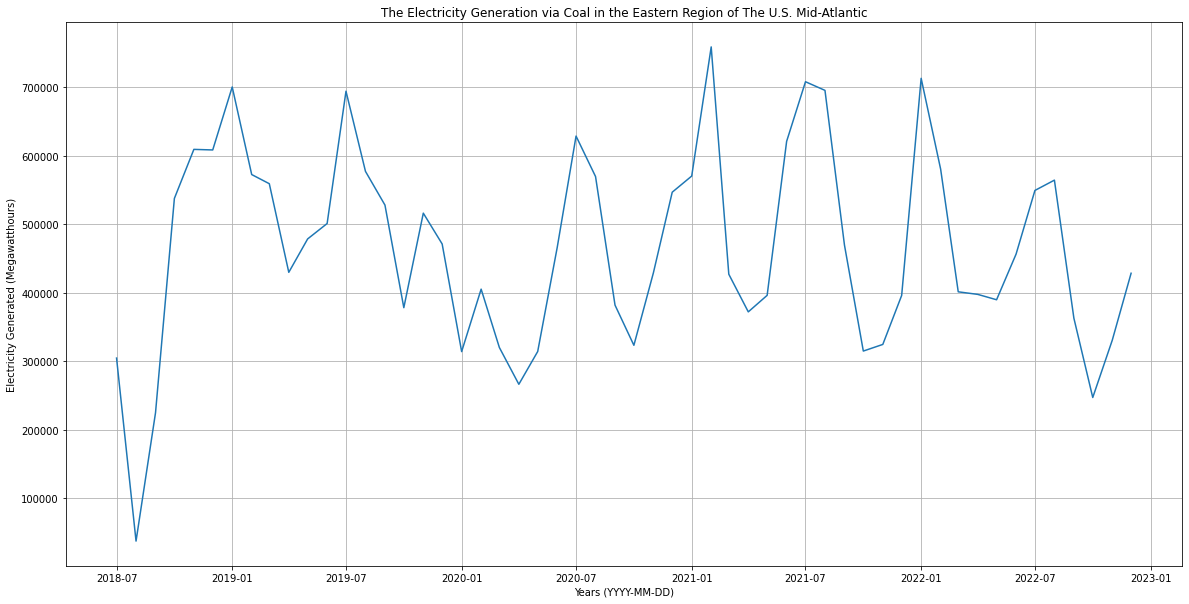

In [170]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(col)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

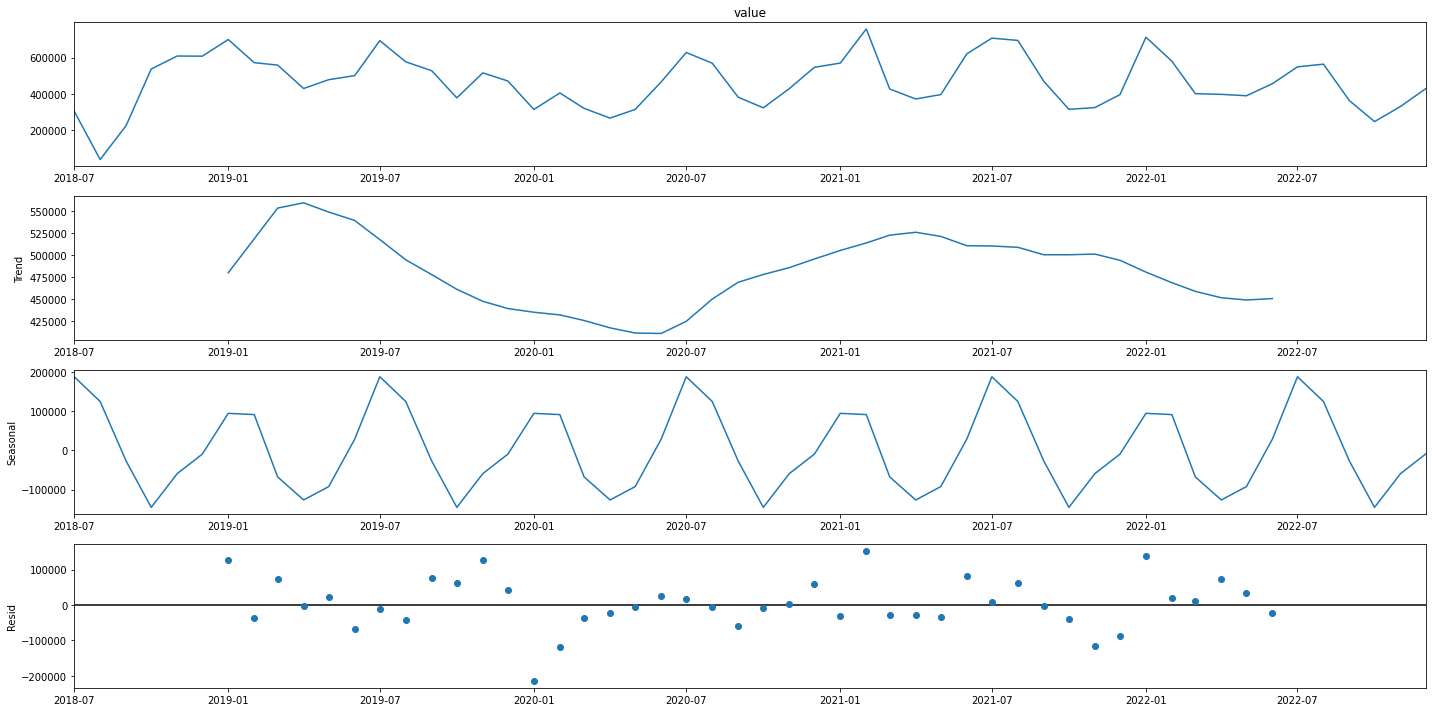

In [171]:
decomposition = sm.tsa.seasonal_decompose(col, model='additive')
decomposition.plot()
plt.show()

In [172]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(col,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1541.3897508497364
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1168.108227177305
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1107.481489385822
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2661.340313256357
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1137.5763655667802
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1139.0311371986663
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:785.0880100217136
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:782.3037630394025
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1479.097970170276
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1133.0932819981317
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1058.3455212609863
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2594.7144249891253
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1188.6449098139146
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1133.875459563546
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:786.837655160255
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:735.674344619307
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1379.0271443030344
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1055.6602451910426
ARI



>**As you can see, the above output tell us that SARIMAX(0, 0, 1)x(1, 1, 1, 12) yields the lowest AIC value of 628.65. This mean that we must consider this option to be the most optimal one available.**



In [182]:
mod = sm.tsa.statespace.SARIMAX(col,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054      1.686      0.003      0.997      -3.300       3.310
ma.L1          0.1834      1.722      0.106      0.915      -3.192       3.559
ar.S.L12      -0.5332      0.202     -2.646      0.008      -0.928      -0.138
ma.S.L12       0.1789      0.395      0.453      0.651      -0.596       0.953
sigma2      1.288e+10   3.93e-10   3.28e+19      0.000    1.29e+10    1.29e+10


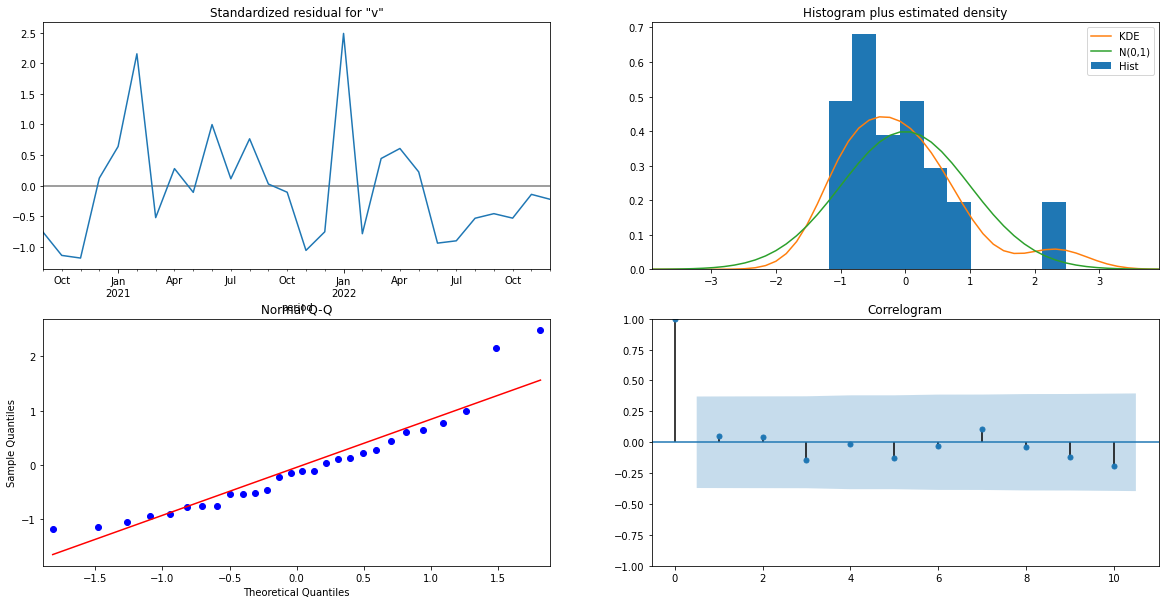

In [183]:
results.plot_diagnostics()
plt.show()

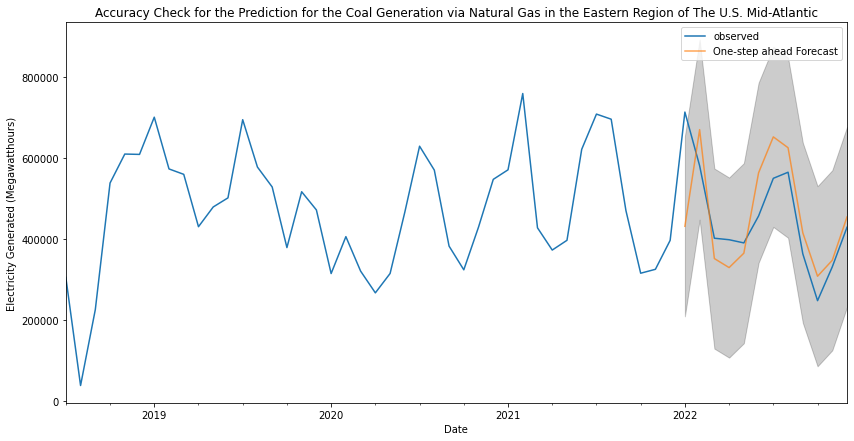

In [184]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = col.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Coal Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [185]:
col_forecasted = pred.predicted_mean
col_truth = col['2022-01-01':]
mse = ((col_forecasted - col_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10684953788.86


In [186]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 103368.05


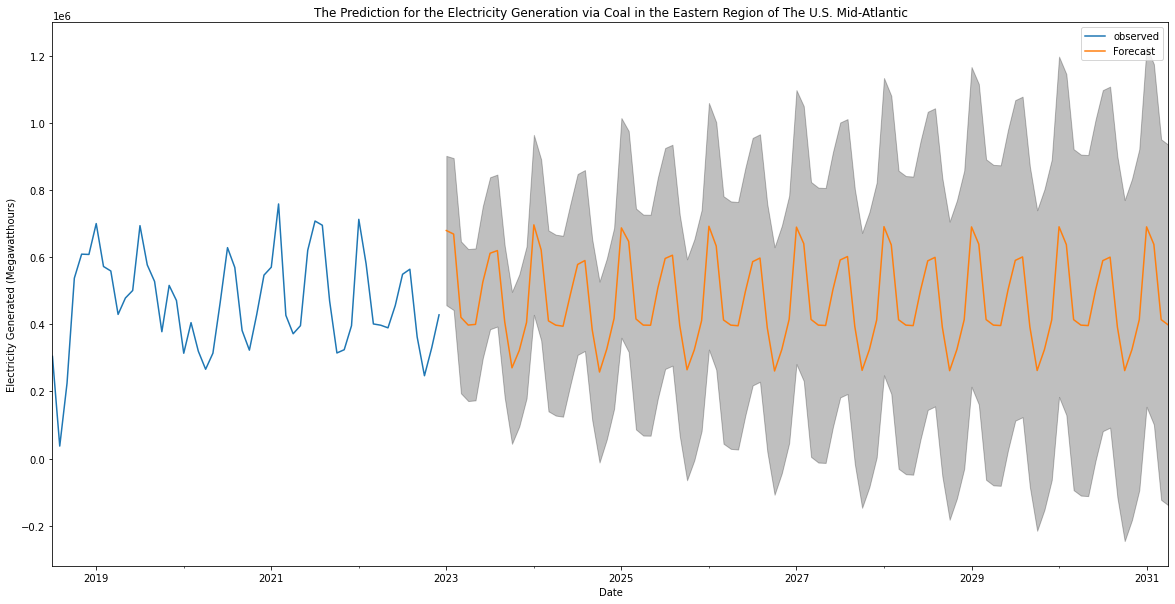

In [187]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = col.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [188]:
nucUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=NUC&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(nucUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

nucDf = pd.DataFrame(json_data.get('response').get('data'))
nucDf['period'] = pd.to_datetime(nucDf['period'])

nucDf = nucDf.sort_values('period')
nucDf.isnull().sum()

nucDf = nucDf.groupby('period')['value'].sum().reset_index()

nucDf = nucDf.set_index('period')
nucDf.index

nuc = nucDf['value'].resample('MS').mean()

nucDf

The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,803906
2018-07-02,803323
2018-07-03,811917
2018-07-04,814756
2018-07-05,812172
...,...
2022-12-05,773325
2022-12-06,771935
2022-12-07,770626


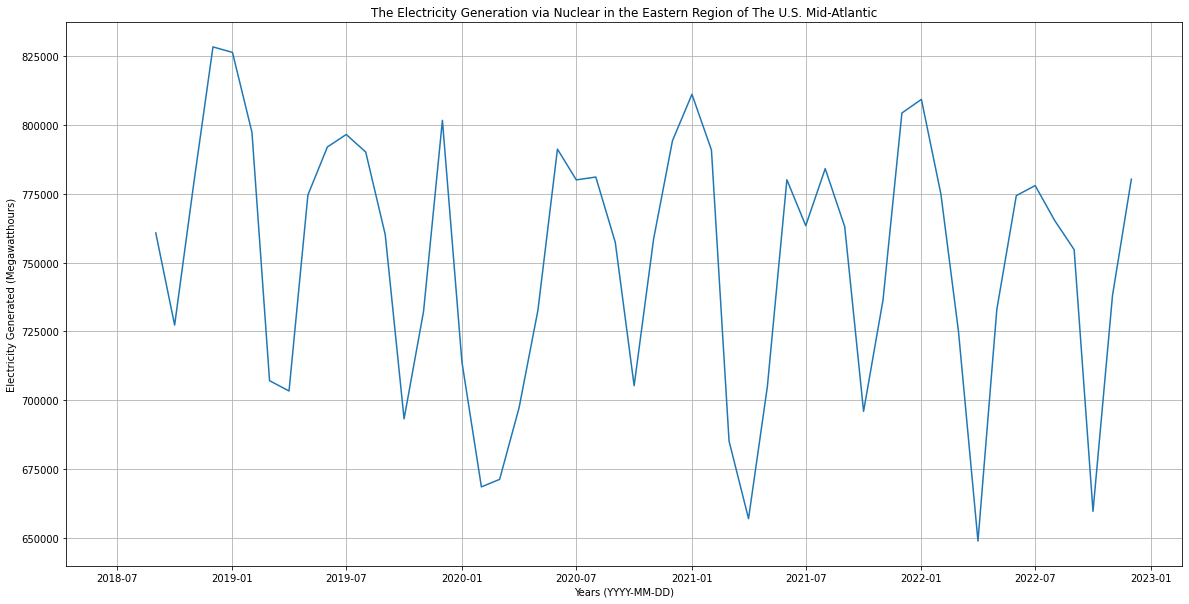

In [189]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(nuc)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

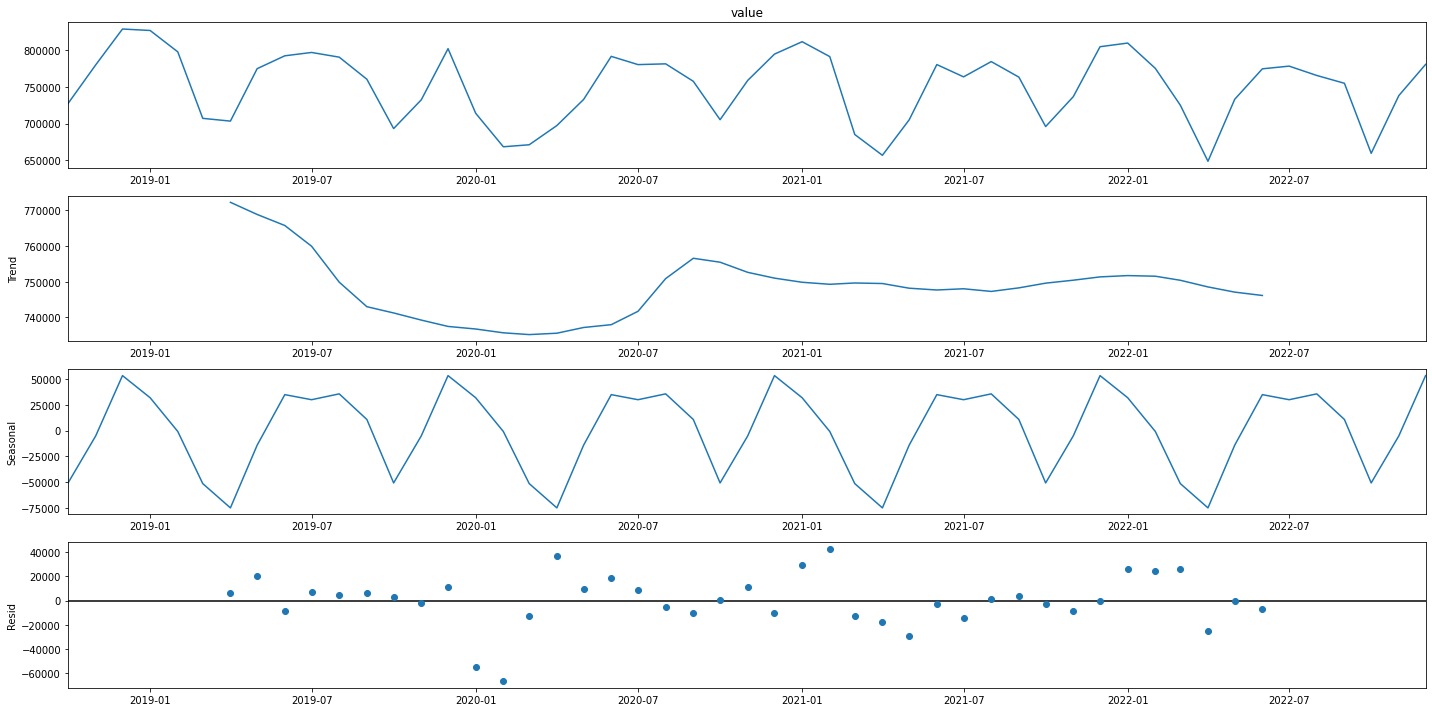

In [190]:
decomposition = sm.tsa.seasonal_decompose(nuc['2018-10-01':], model='additive')
decomposition.plot()
plt.show()

In [191]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(nuc['2018-10-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1526.8546154021385
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1506.074648635382
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:945.8964707404806
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1673.927459254599
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1305.4514233838545
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1294.814333205141
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:938.4793040301197
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1962.583165451195
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1493.4672952607705
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1578.0096247190324
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:951.3753065099176
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1711.6152330232499
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1489.5502305800721
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1491.3208113101657
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:933.7609760219239
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1824.9514737647723
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1224.7633058268393
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1275.408157783455
A

In [198]:
mod = sm.tsa.statespace.SARIMAX(nuc['2018-10-01':],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0094      0.109     -0.087      0.931      -0.222       0.204
ar.S.L12      -0.0739      0.043     -1.705      0.088      -0.159       0.011
sigma2      1.662e+09   1.05e-11   1.58e+20      0.000    1.66e+09    1.66e+09


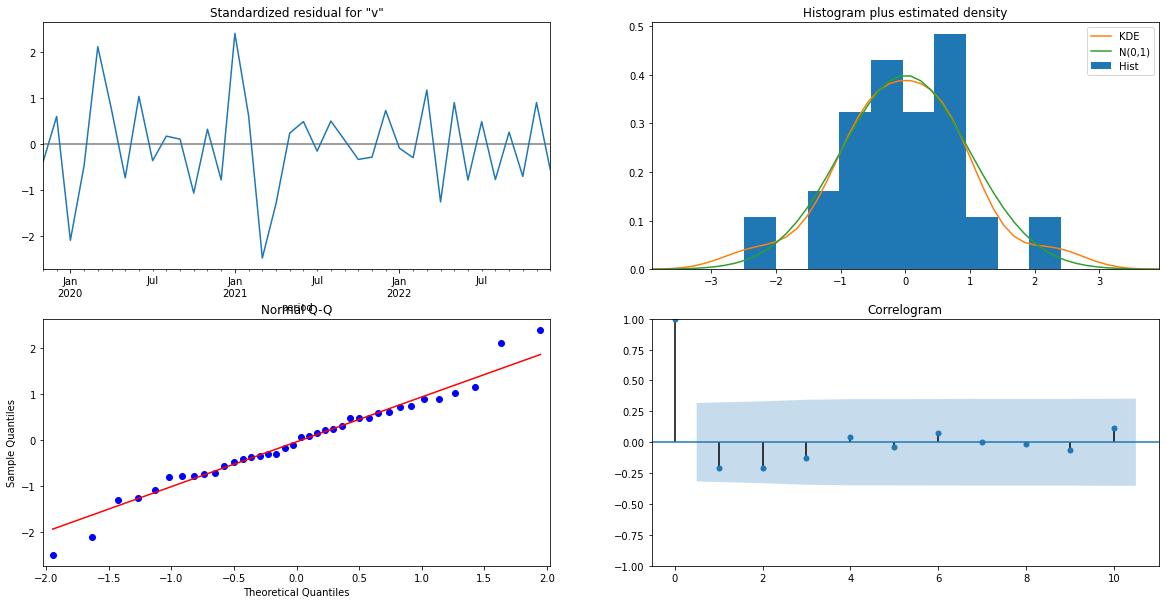

In [199]:
results.plot_diagnostics()
plt.show()

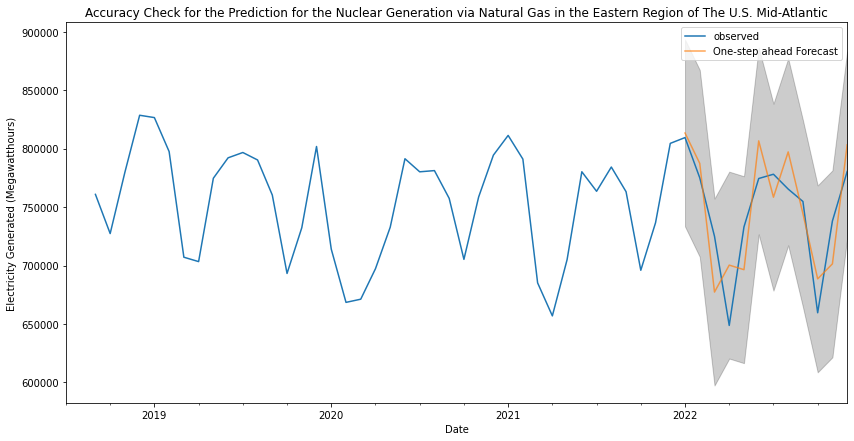

In [200]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = nuc['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Nuclear Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [201]:
nuc_forecasted = pred.predicted_mean
nuc_truth = nuc['2022-01-01':]
mse = ((nuc_forecasted - nuc_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 973821825.63


In [202]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 31206.12


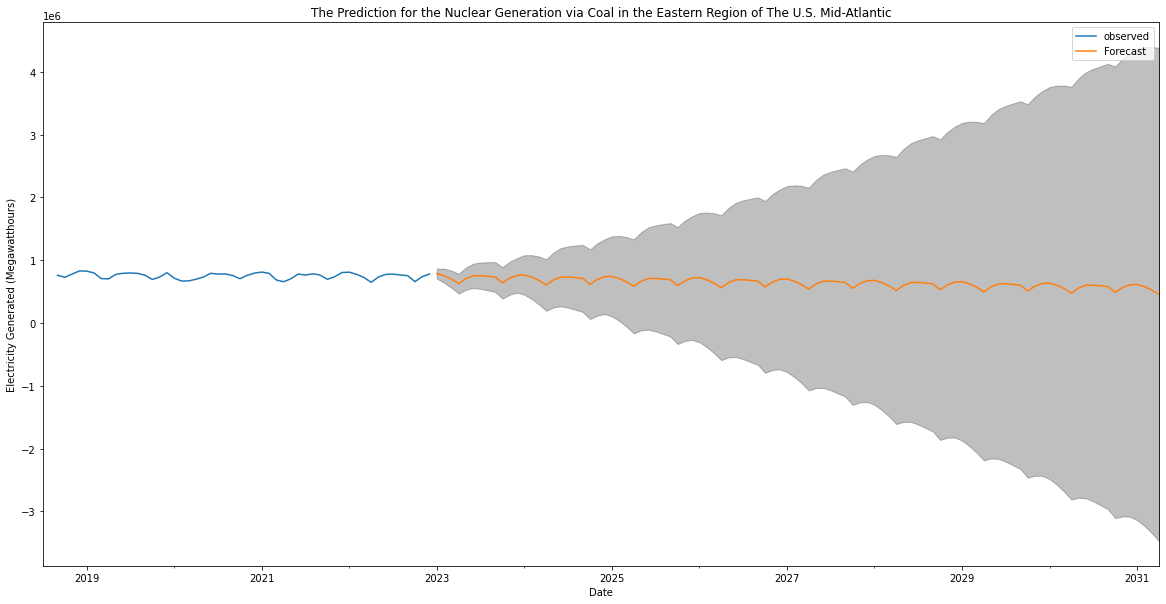

In [203]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = nuc.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Nuclear Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [204]:
watUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=WAT&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(watUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

watDf = pd.DataFrame(json_data.get('response').get('data'))
watDf['period'] = pd.to_datetime(watDf['period'])

watDf = watDf.sort_values('period')
watDf.isnull().sum()

watDf = watDf.groupby('period')['value'].sum().reset_index()

watDf = watDf.set_index('period')
watDf.index

wat = watDf['value'].resample('MS').mean()

watDf

The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,54169
2018-07-02,65488
2018-07-03,58860
2018-07-04,51415
2018-07-05,59848
...,...
2022-12-05,51786
2022-12-06,43438
2022-12-07,41240


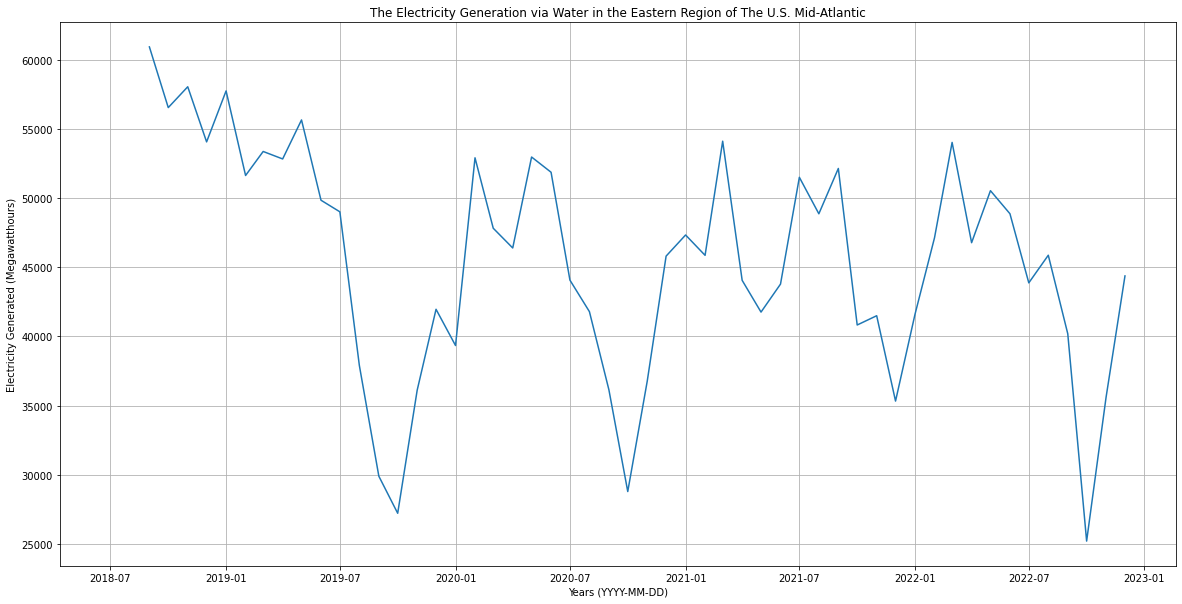

In [205]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(wat)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

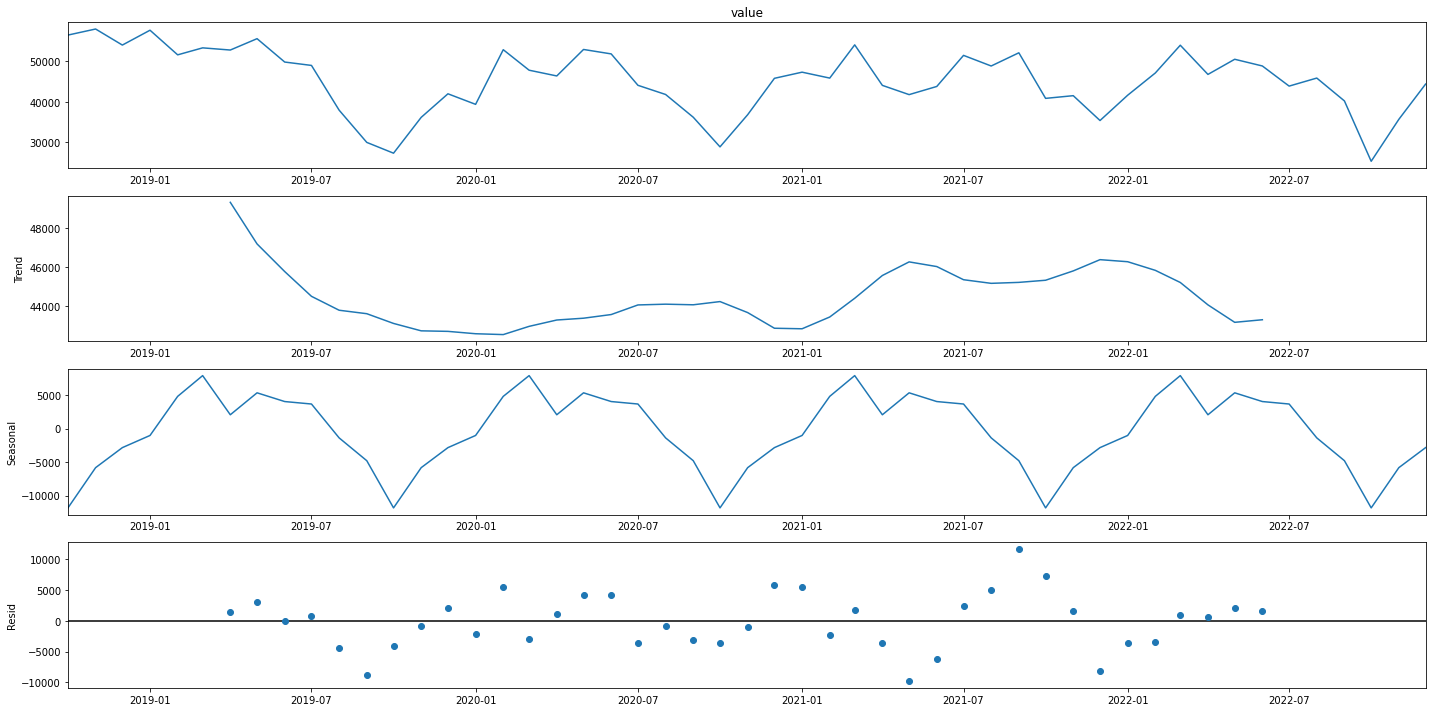

In [206]:
decomposition = sm.tsa.seasonal_decompose(wat['2018-10-01':], model='additive')
decomposition.plot()
plt.show()

In [207]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(wat['2018-10-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1216.8606578982126
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:892.0996493347496
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:798.866768945236
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:924.3074234962438
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:826.6109480266788
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:793.4882474654679
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:560.2421875237098
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1054.1840763126104
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1160.3552623951305
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:872.2209593228175
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:766.3798294646516
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1062.5269702395483
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:824.6452181304365
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:869.0211850763194
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:556.2698873922163
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.0446990828925
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1001.3190112377501
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:761.2750806523038
ARIMA(

In [208]:
mod = sm.tsa.statespace.SARIMAX(wat['2018-10-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5653      0.308      1.834      0.067      -0.039       1.169
ma.L1         -0.7900      0.196     -4.034      0.000      -1.174      -0.406
ar.S.L12       0.2947      0.283      1.040      0.298      -0.261       0.850
ma.S.L12      -0.6142      0.358     -1.713      0.087      -1.317       0.088
sigma2      6.026e+07   2.78e-09   2.16e+16      0.000    6.03e+07    6.03e+07


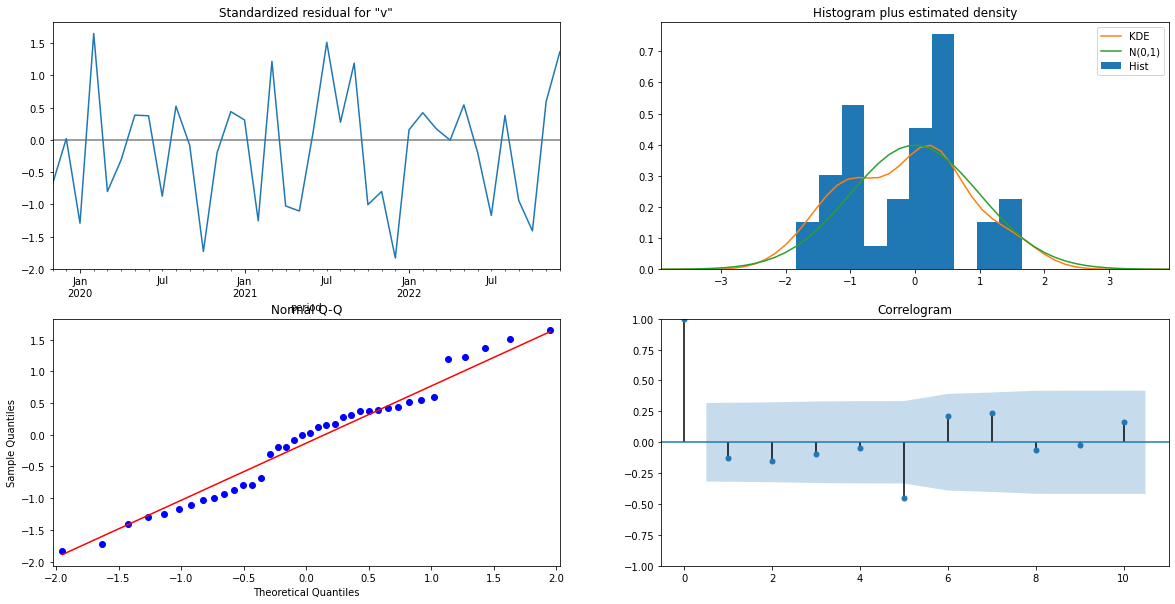

In [209]:
results.plot_diagnostics()
plt.show()

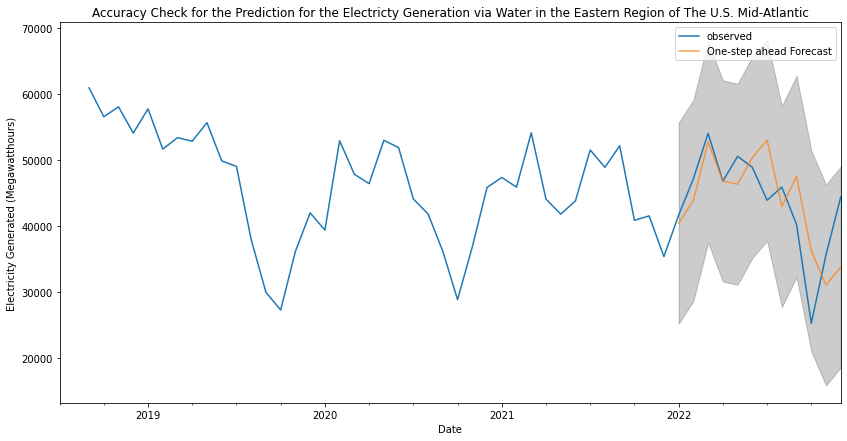

In [210]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = wat['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricty Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [211]:
wat_forecasted = pred.predicted_mean
wat_truth = wat['2022-01-01':]
mse = ((wat_forecasted - wat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36094248.96


In [212]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6007.85


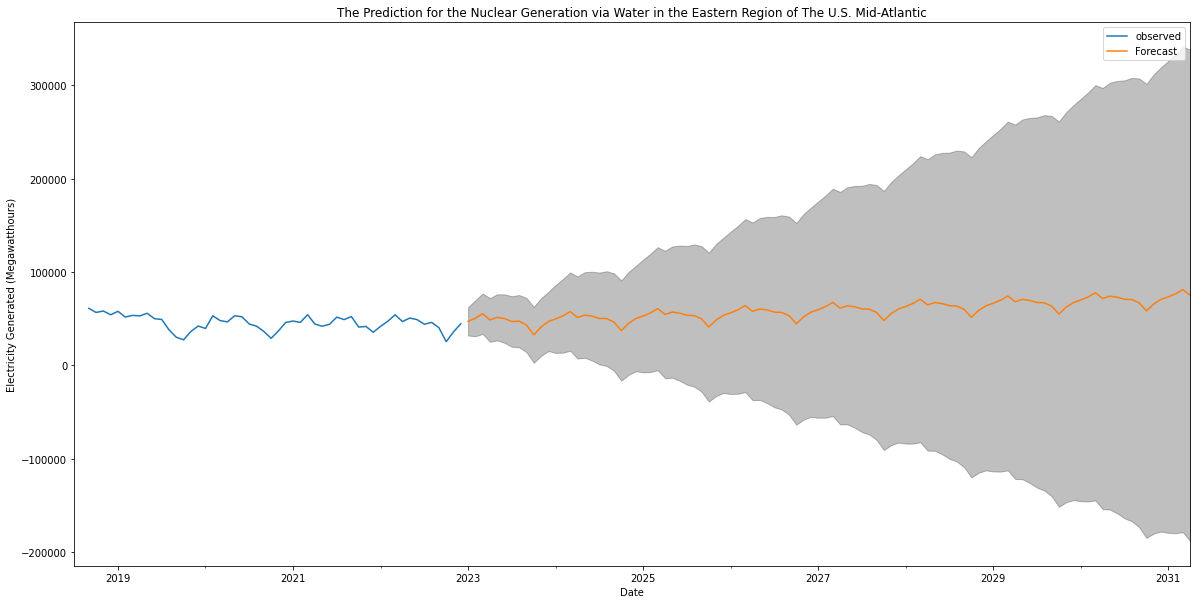

In [213]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = wat['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Nuclear Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [214]:
ngUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=NG&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(ngUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

ngDf = pd.DataFrame(json_data.get('response').get('data'))
ngDf['period'] = pd.to_datetime(ngDf['period'])

ngDf = ngDf.sort_values('period')
ngDf.isnull().sum()

ngDf = ngDf.groupby('period')['value'].sum().reset_index()

ngDf = ngDf.set_index('period')
ngDf.index

ng = ngDf['value'].resample('MS').mean()

ngDf

The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,916254
2018-07-02,1030842
2018-07-03,1013122
2018-07-04,920407
2018-07-05,1031095
...,...
2022-12-05,1005420
2022-12-06,997967
2022-12-07,893228


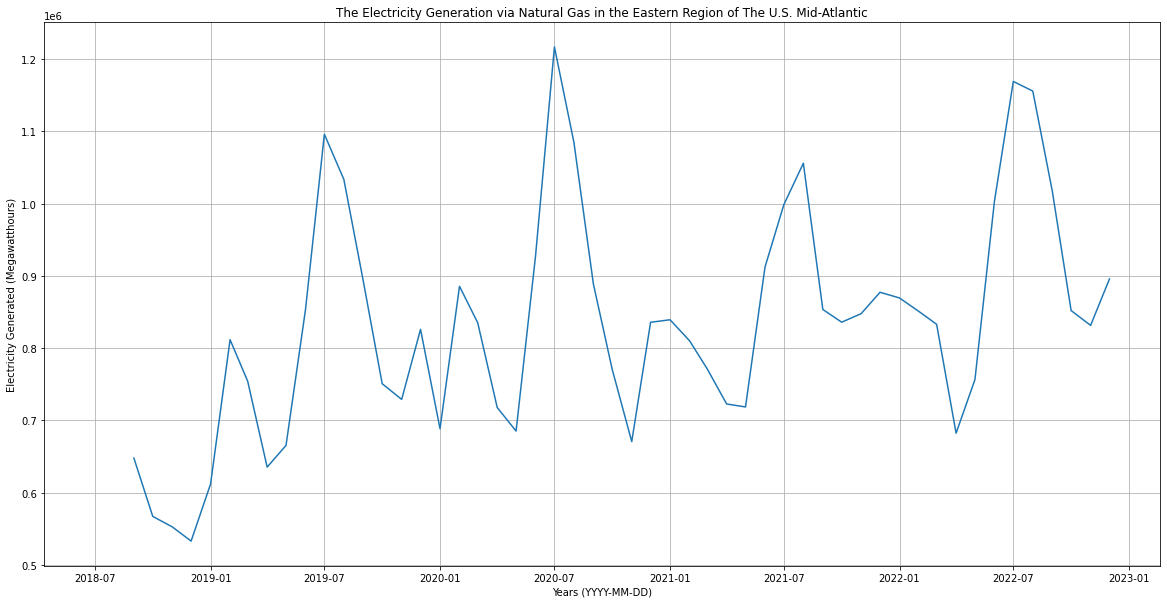

In [215]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(ng)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

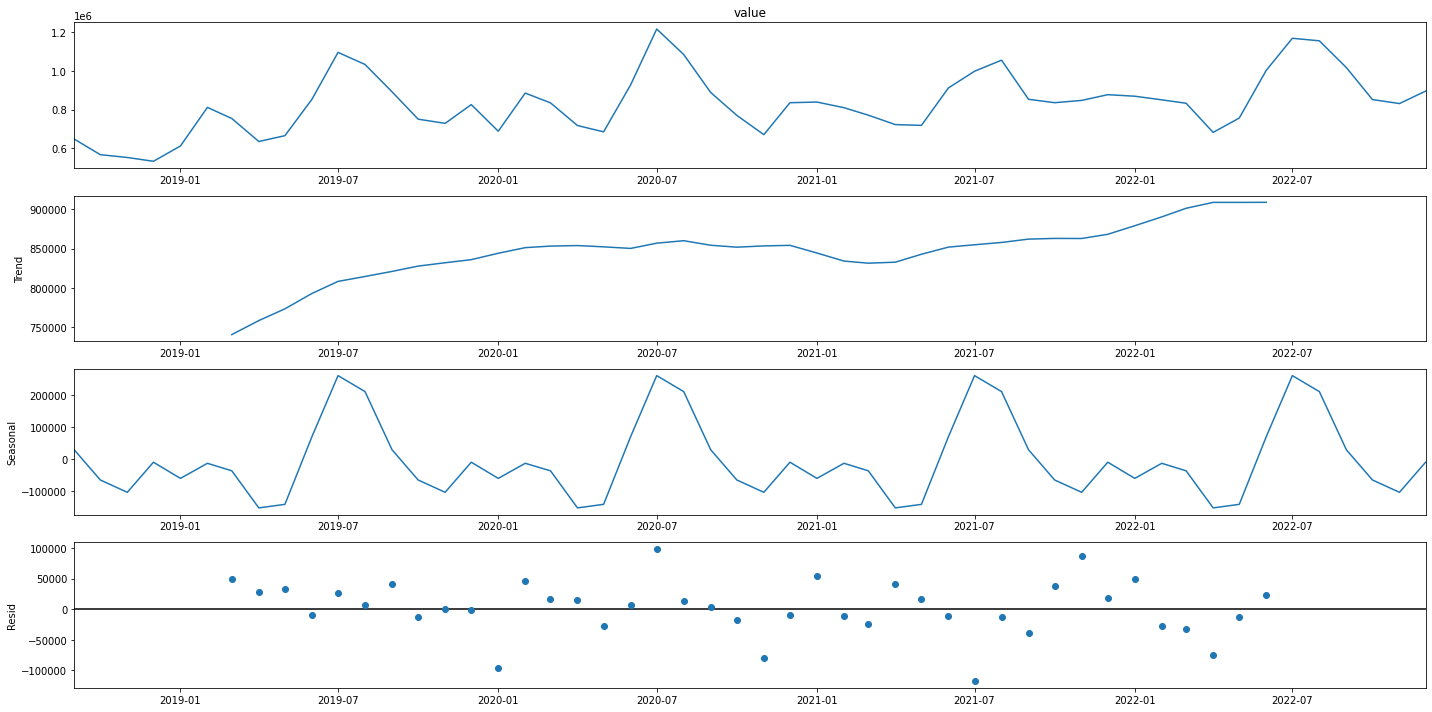

In [216]:
decomposition = sm.tsa.seasonal_decompose(ng['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [217]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ng['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1539.4724591214076
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1155.4191708831363
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1012.895864906252
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1189.1609941563026
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1037.4025797301153
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1017.9749178740383
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:717.0478309600362
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1155.4756495057022
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1476.7006793158102
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1117.3954273906234
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:976.5700223131217
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2373.2225910396082
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1172.3620853504663
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1116.0088339822062
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:714.9058804210483
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2404.8681513943957
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1318.7923515591744
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:984.45561247109

In [218]:
mod = sm.tsa.statespace.SARIMAX(ng['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5778      0.632      0.914      0.361      -0.662       1.817
ma.L1         -0.6542      0.621     -1.053      0.292      -1.871       0.563
ar.S.L12       0.5978      0.158      3.774      0.000       0.287       0.908
ma.S.L12      -0.9694      0.348     -2.788      0.005      -1.651      -0.288
sigma2      6.841e+09   5.75e-11   1.19e+20      0.000    6.84e+09    6.84e+09


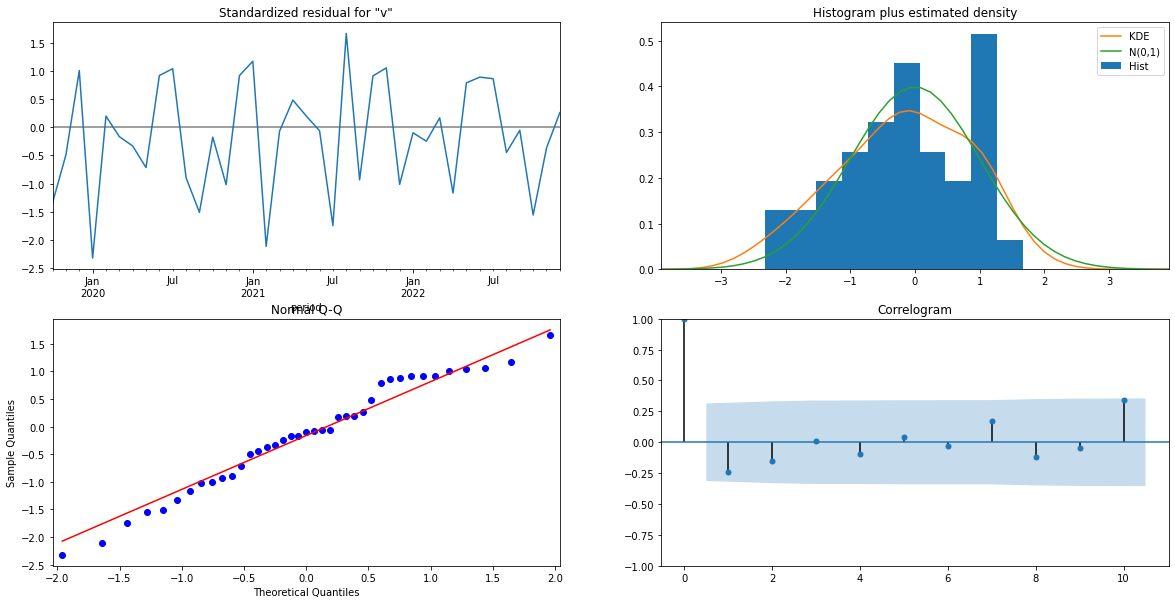

In [219]:
results.plot_diagnostics()
plt.show()

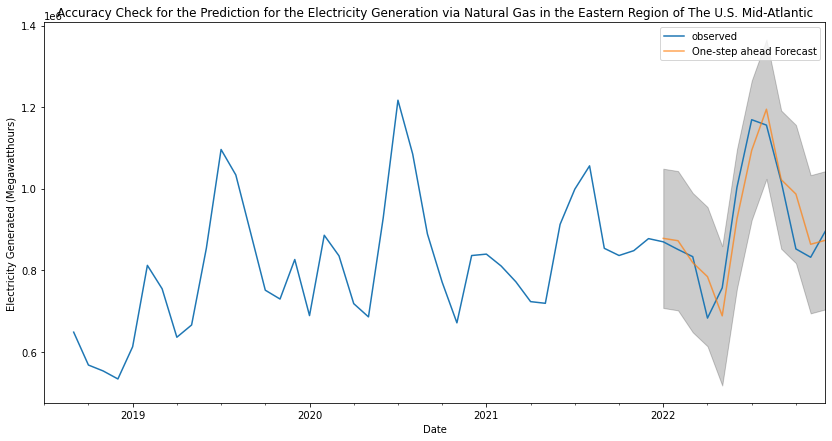

In [220]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ng['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [221]:
ng_forecasted = pred.predicted_mean
ng_truth = ng['2022-01-01':]
mse = ((ng_forecasted - ng_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4054648456.26


In [222]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 63676.12


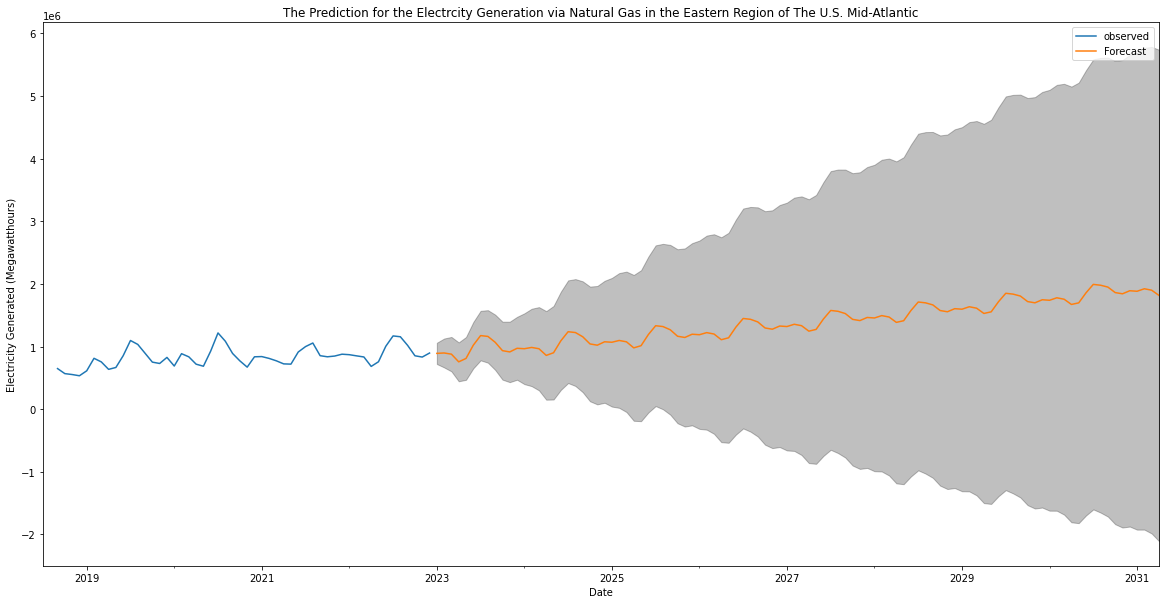

In [223]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ng['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [224]:
oilUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=OIL&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(oilUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

oilDf = pd.DataFrame(json_data.get('response').get('data'))
oilDf['period'] = pd.to_datetime(oilDf['period'])

oilDf = oilDf.sort_values('period')
oilDf.isnull().sum()

oilDf = oilDf.groupby('period')['value'].sum().reset_index()

oilDf = oilDf.set_index('period')
oilDf.index

oil = oilDf['value'].resample('MS').mean()

oilDf

The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,9290
2018-07-02,7913
2018-07-03,12365
2018-07-04,4352
2018-07-05,4823
...,...
2022-12-05,2545
2022-12-06,4735
2022-12-07,4535


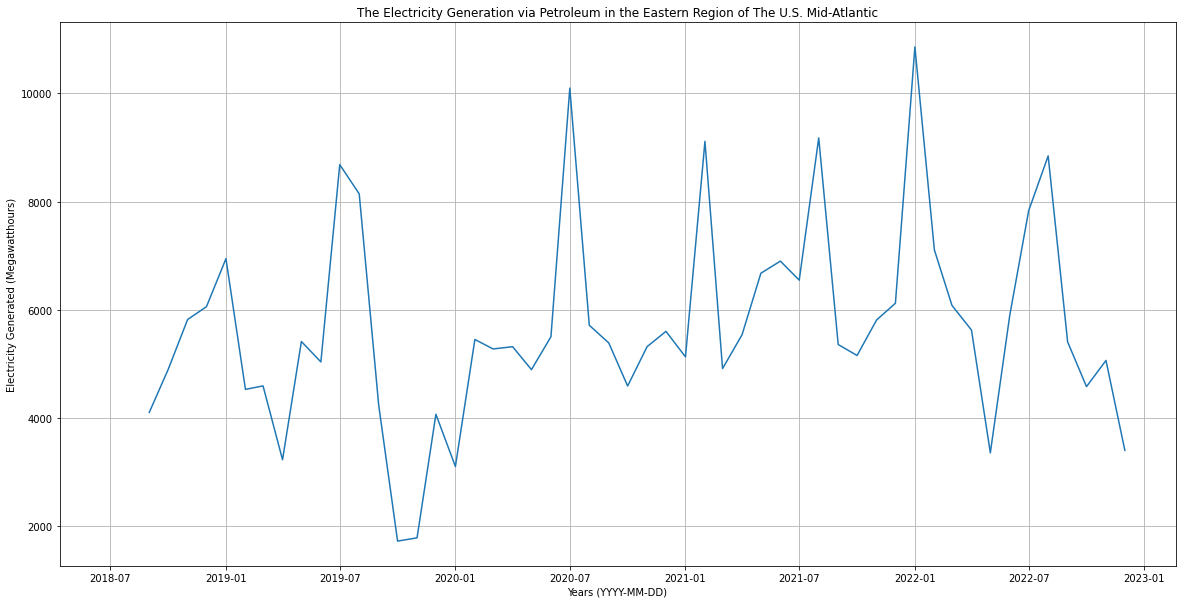

In [225]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(oil)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

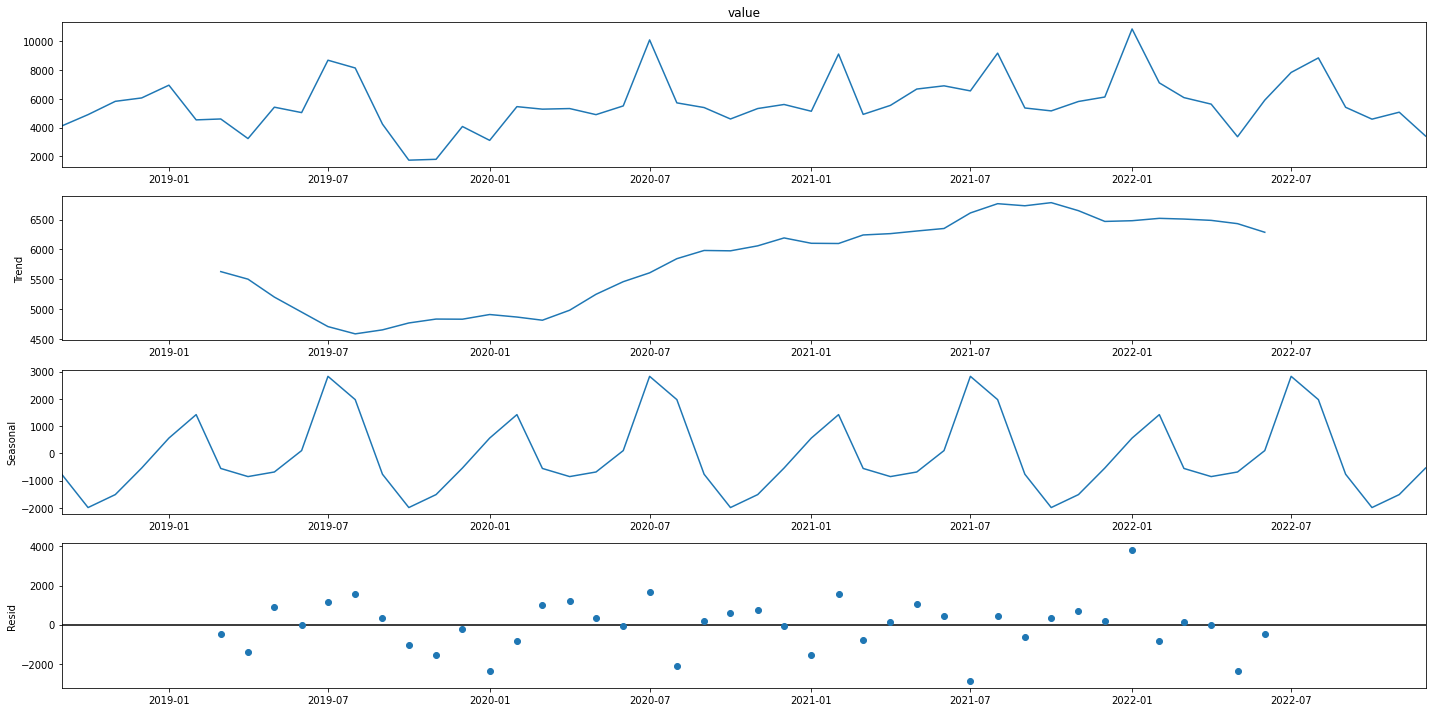

In [107]:
decomposition = sm.tsa.seasonal_decompose(oil['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [226]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(oil['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1034.391116140206
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:774.4240454261245
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:713.6310971282231
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1101.7333482904712
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:732.5541303441328
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:709.1972991396573
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:509.32722255953985
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1346.776484334659
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:968.5118670851502
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:722.2282456049467
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:695.7511117816375
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1083.4031215955229
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:733.6079292229241
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:692.9841641034085
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:511.07328110329956
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1065.3837837020117
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:911.0987791895466
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:695.935378533324
ARIMA(

In [227]:
mod = sm.tsa.statespace.SARIMAX(oil['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3152      0.228      1.384      0.166      -0.131       0.762
ma.L1         -0.9012      0.293     -3.072      0.002      -1.476      -0.326
ar.S.L12      -0.5032      0.224     -2.244      0.025      -0.943      -0.064
sigma2      5.308e+06   1.52e+06      3.486      0.000    2.32e+06    8.29e+06


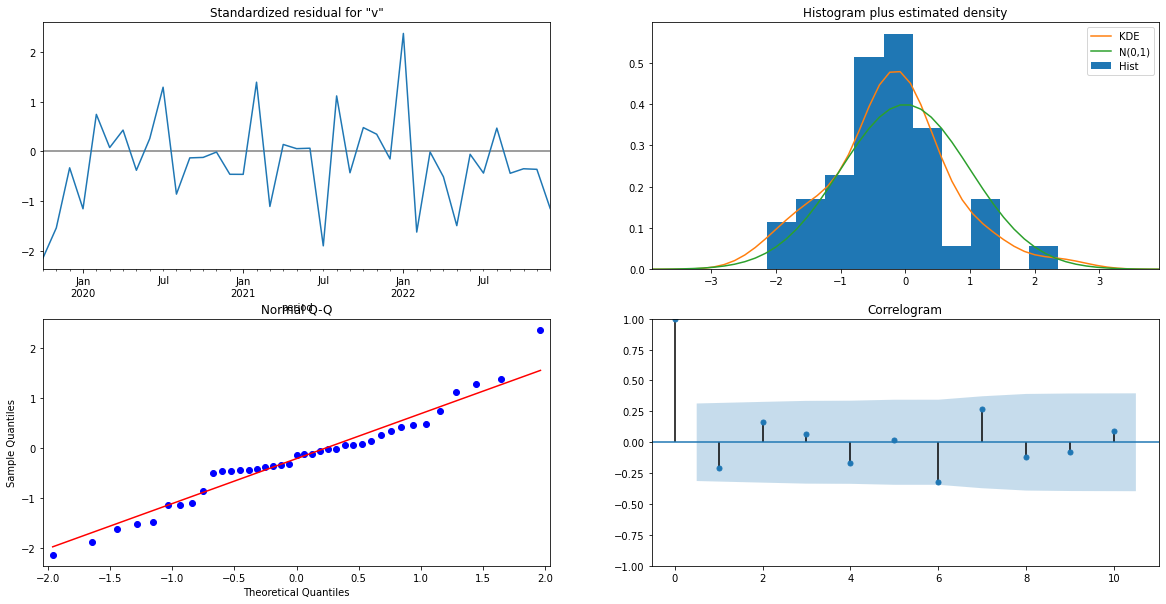

In [228]:
results.plot_diagnostics()
plt.show()

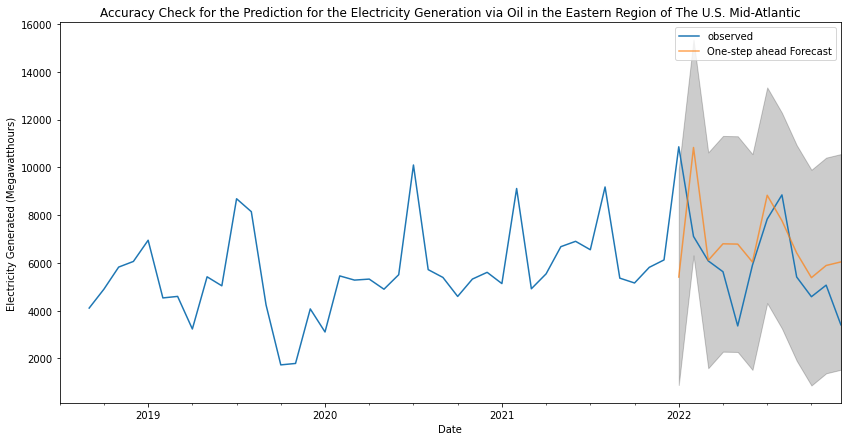

In [229]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = oil['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Oil in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [230]:
oil_forecasted = pred.predicted_mean
oil_truth = oil['2022-01-01':]
mse = ((oil_forecasted - oil_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5680973.51


In [231]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2383.48


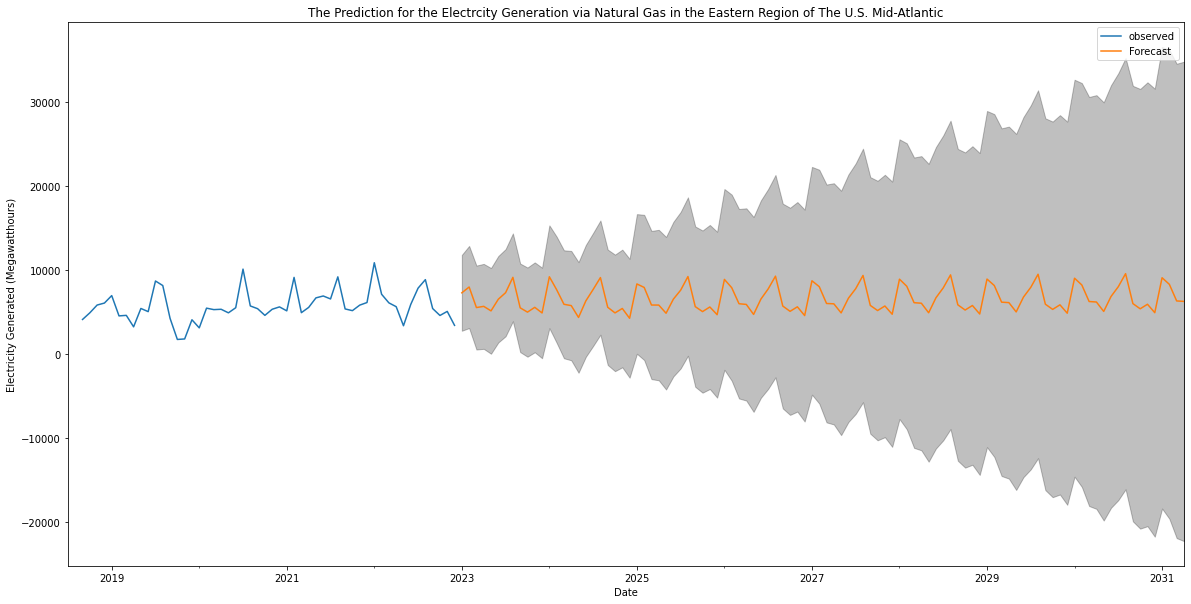

In [232]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = oil['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [233]:
sunUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(sunUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

sunDf = pd.DataFrame(json_data.get('response').get('data'))
sunDf['period'] = pd.to_datetime(sunDf['period'])

sunDf = sunDf.sort_values('period')
sunDf.isnull().sum()

sunDf = sunDf.groupby('period')['value'].sum().reset_index()

sunDf = sunDf.set_index('period')
sunDf.index

sun = sunDf['value'].resample('MS').mean()

sunDf

The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,7797
2018-07-02,8081
2018-07-03,7507
2018-07-04,5985
2018-07-05,6669
...,...
2022-12-05,11134
2022-12-06,3505
2022-12-07,2959


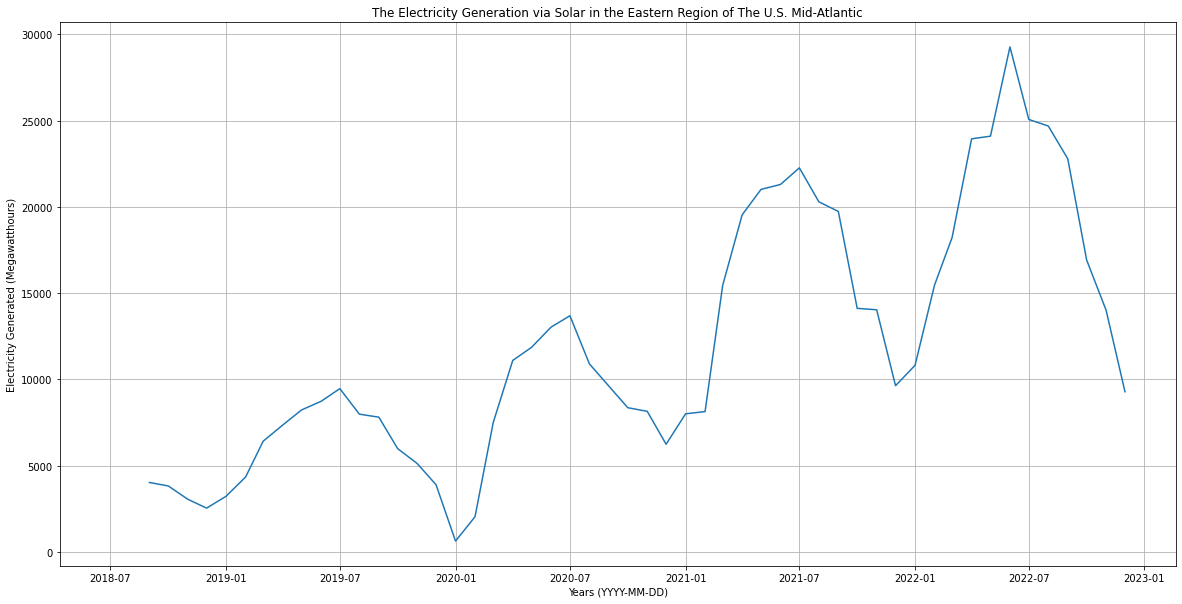

In [234]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(sun)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

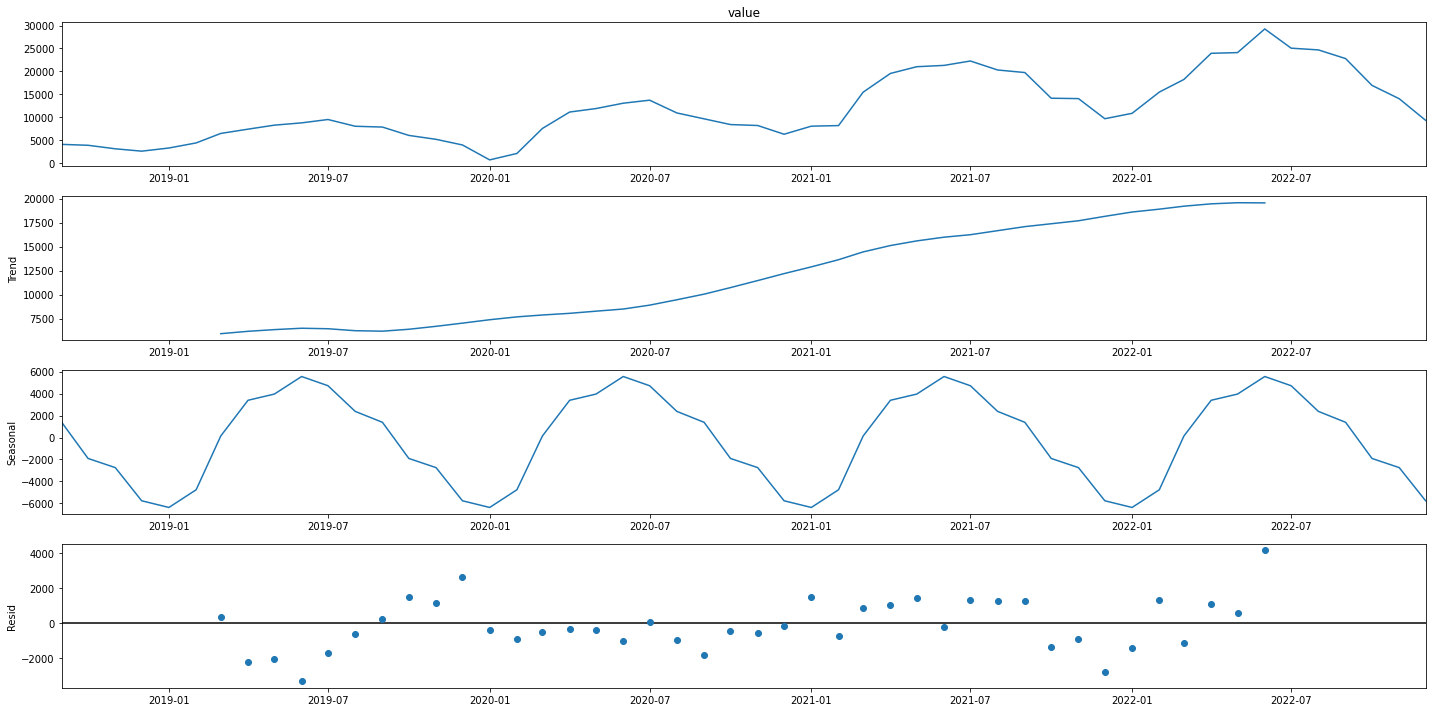

In [235]:
decomposition = sm.tsa.seasonal_decompose(sun['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [236]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sun['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1121.122302414845
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:853.0687321763522
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:779.9130649254453
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1115.7365004597825
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:768.2012015266669
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:754.5372948378724
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:556.12596857319
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:970.5694400026161
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1066.9794831137424
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:808.9824390697183
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:743.8645495429919
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1061.0347325164048
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:755.3300038259508
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:805.2725594743532
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:551.112189316903
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1056.180008592806
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:938.4198489359849
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:709.7294711854473
ARIMA(0, 1

In [237]:
mod = sm.tsa.statespace.SARIMAX(sun['2018-09-01':],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3073      0.170     -1.813      0.070      -0.640       0.025
ar.S.L12      -0.0400      0.205     -0.195      0.845      -0.442       0.362
sigma2      4.755e+06   1.17e+06      4.051      0.000    2.45e+06    7.06e+06


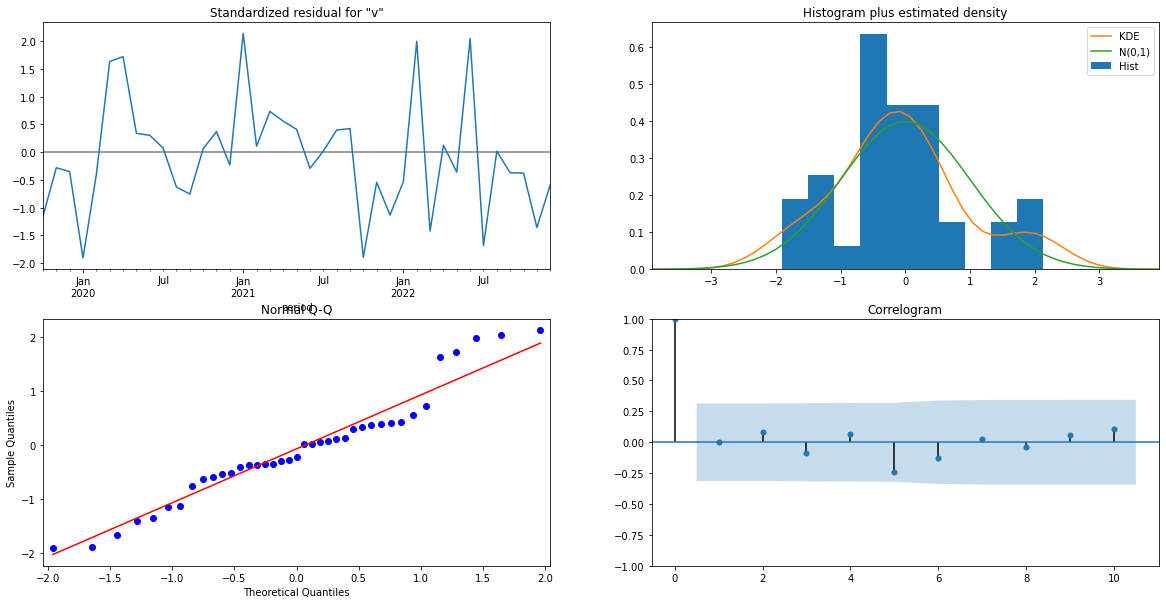

In [238]:
results.plot_diagnostics()
plt.show()

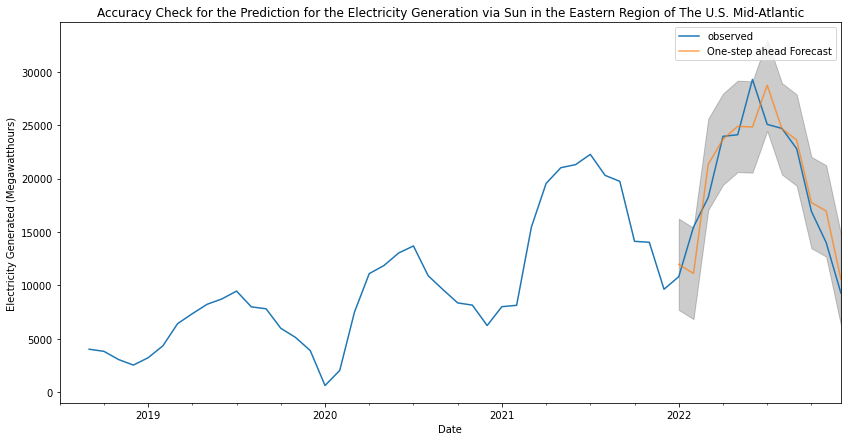

In [239]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sun['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Sun in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [240]:
sun_forecasted = pred.predicted_mean
sun_truth = sun['2022-01-01':]
mse = ((sun_forecasted - sun_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6299665.39


In [241]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2509.91


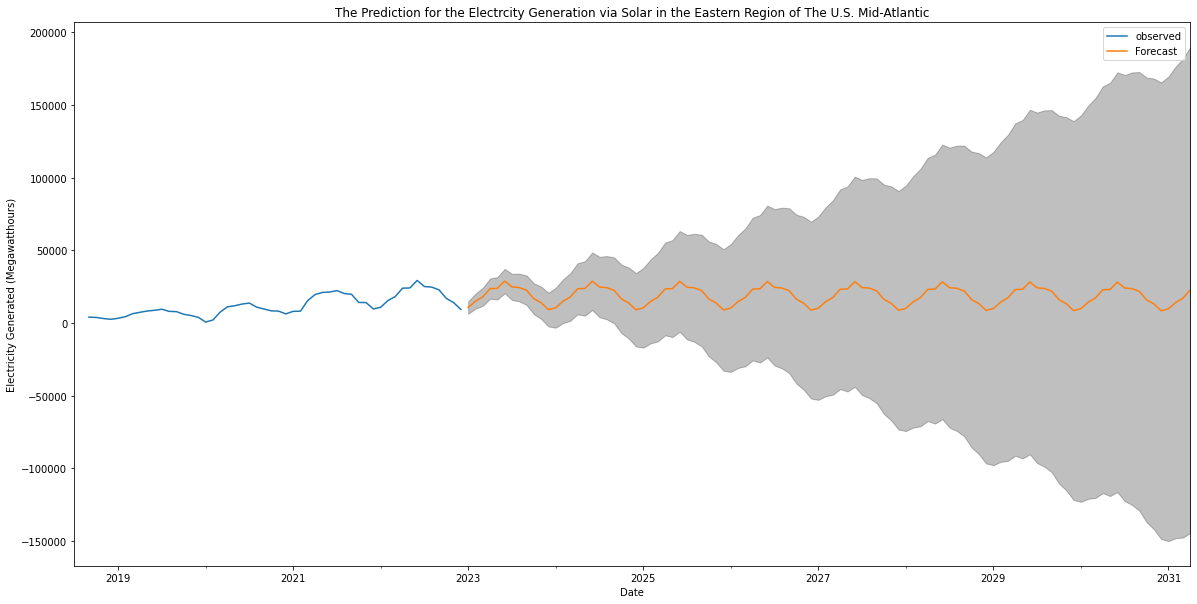

In [242]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = sun.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [243]:
wndUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=WND&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(wndUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

wndDf = pd.DataFrame(json_data.get('response').get('data'))
wndDf['period'] = pd.to_datetime(wndDf['period'])

wndDf = wndDf.sort_values('period')
wndDf.isnull().sum()

wndDf = wndDf.groupby('period')['value'].sum().reset_index()

wndDf = wndDf.set_index('period')
wndDf.index

wnd = wndDf['value'].resample('MS').mean()

wndDf

The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,51429
2018-07-02,14217
2018-07-03,14028
2018-07-04,12712
2018-07-05,20718
...,...
2022-12-05,84214
2022-12-06,31410
2022-12-07,25674


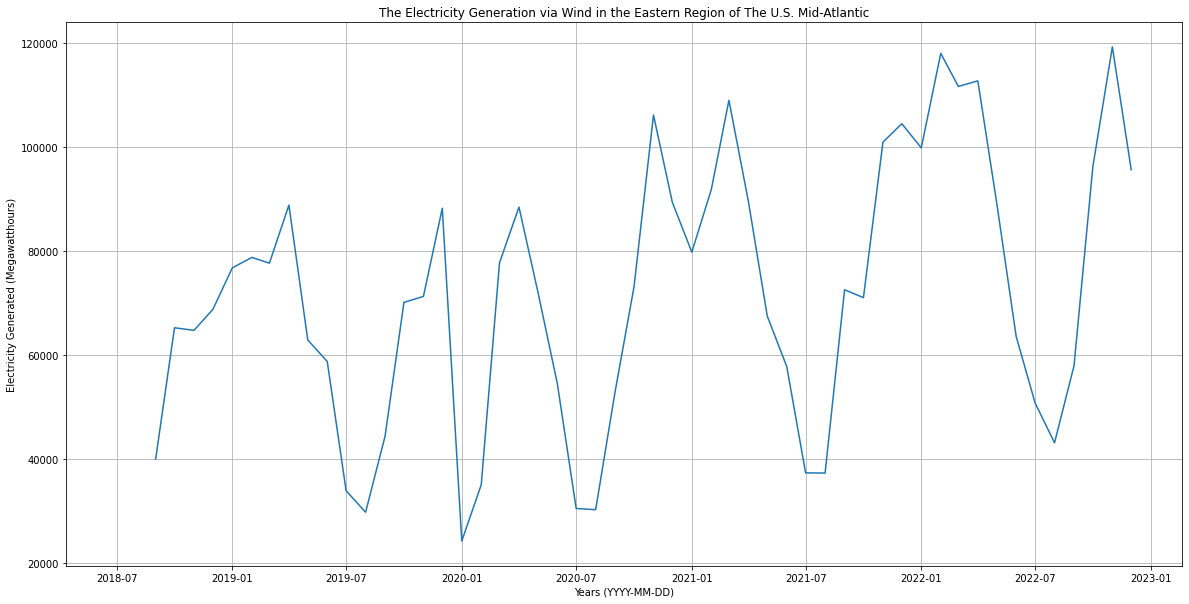

In [244]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(wnd)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

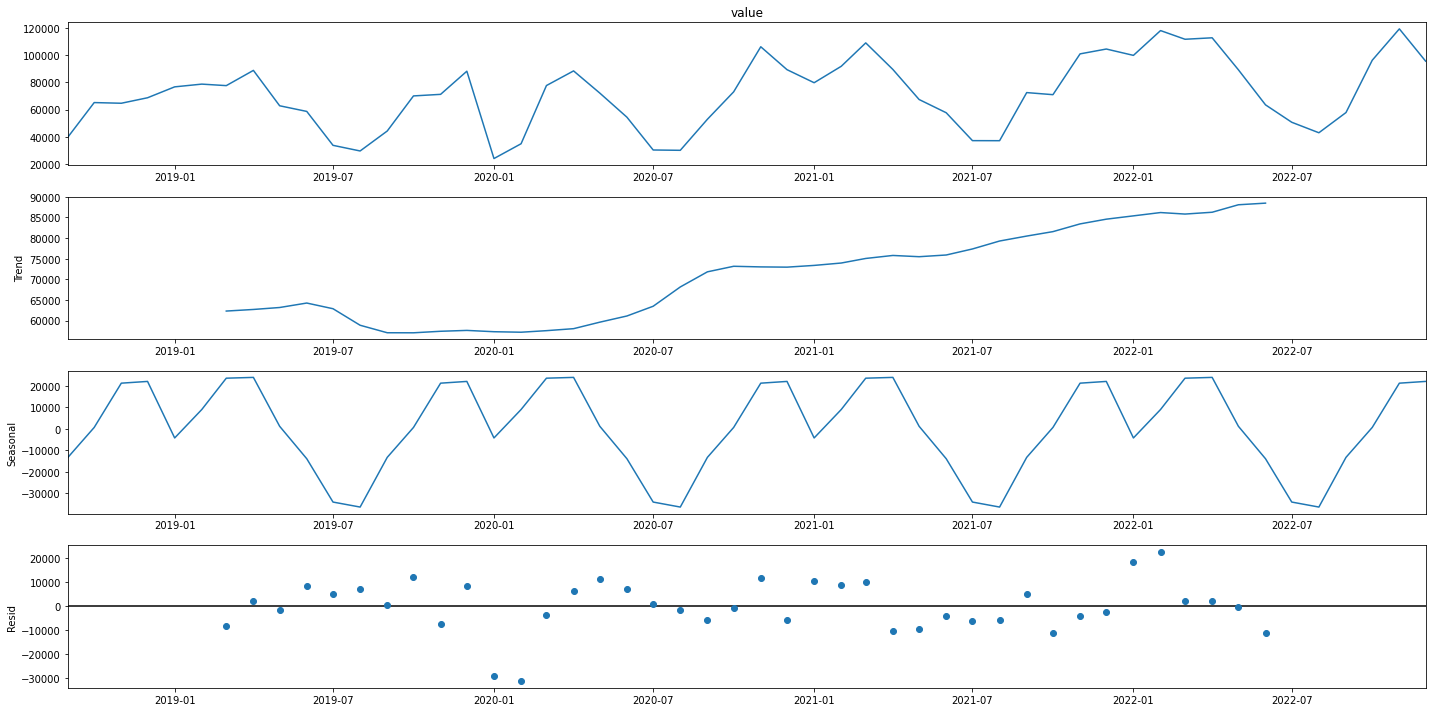

In [245]:
decomposition = sm.tsa.seasonal_decompose(wnd['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [246]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(wnd['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1293.8880111490087
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:976.465638054015
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:891.2274305032454
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1008.6025554603165
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:911.8529550874613
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:929.1597704031817
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:640.7999352450898
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1322.168670961757
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2945.3079982886134
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:977.3958398218062
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:863.4845201894484
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1206.7103150919804
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1035.5339148699586
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:975.8625450950514
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:634.3410109906097
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1116.9164607775429
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1136.5187576626333
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:867.0665040385818
ARIM

In [247]:
mod = sm.tsa.statespace.SARIMAX(wnd['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3086      0.275      1.123      0.261      -0.230       0.847
ma.L1         -0.7793      0.174     -4.490      0.000      -1.119      -0.439
ar.S.L12      -0.4899      0.142     -3.441      0.001      -0.769      -0.211
sigma2      3.393e+08   9.16e-10   3.71e+17      0.000    3.39e+08    3.39e+08


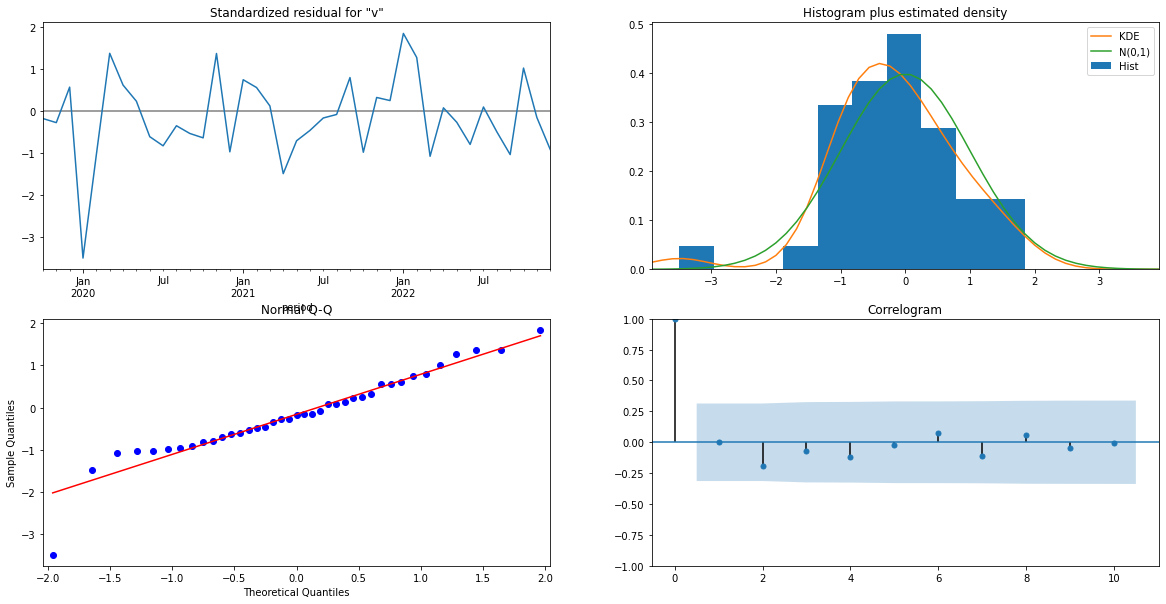

In [248]:
results.plot_diagnostics()
plt.show()

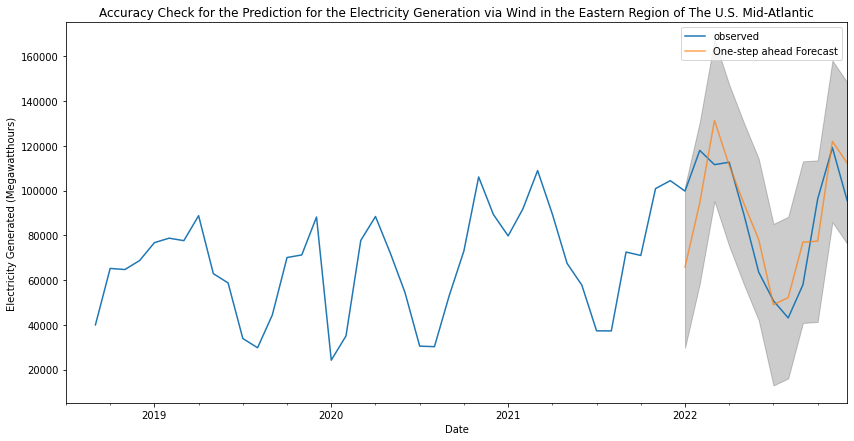

In [249]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = wnd['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [250]:
wnd_forecasted = pred.predicted_mean
wnd_truth = wnd['2022-01-01':]
mse = ((wnd_forecasted - wnd_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 285436576.82


In [251]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 16894.87


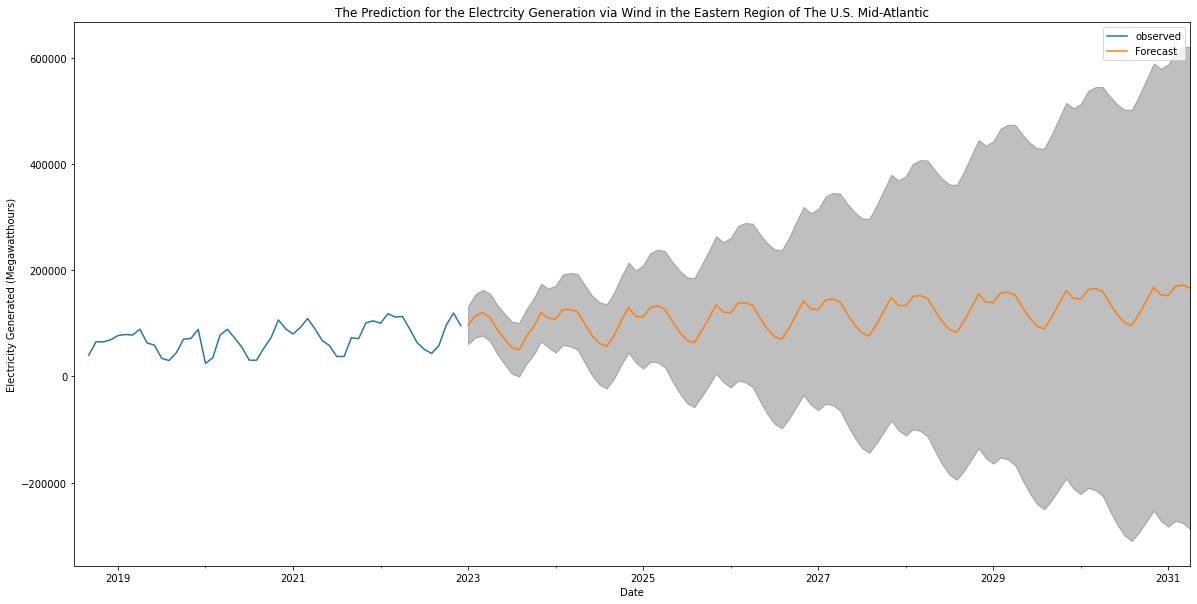

In [252]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = wnd.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [253]:
othUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=OTH&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(othUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

othDf = pd.DataFrame(json_data.get('response').get('data'))
othDf['period'] = pd.to_datetime(othDf['period'])

othDf = othDf.sort_values('period')
othDf.isnull().sum()

othDf = othDf.groupby('period')['value'].sum().reset_index()

othDf = othDf.set_index('period')
othDf.index

oth = othDf['value'].resample('MS').mean()

othDf

The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,44423
2018-07-02,57745
2018-07-03,20024
2018-07-04,19373
2018-07-05,19883
...,...
2022-12-05,23768
2022-12-06,23828
2022-12-07,23255


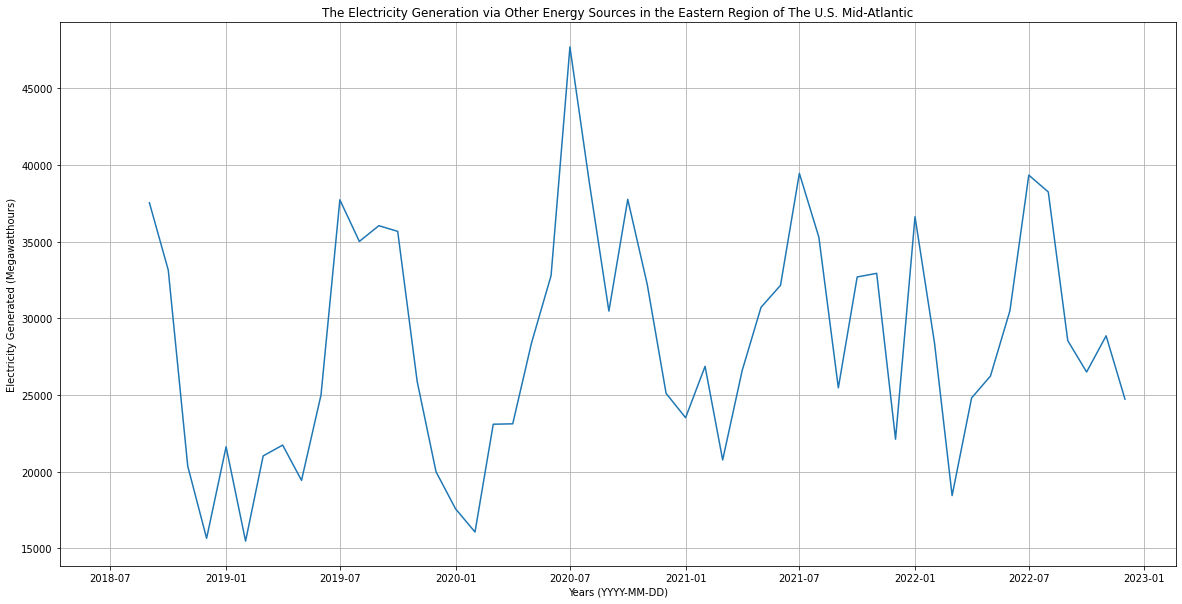

In [254]:

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(oth)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

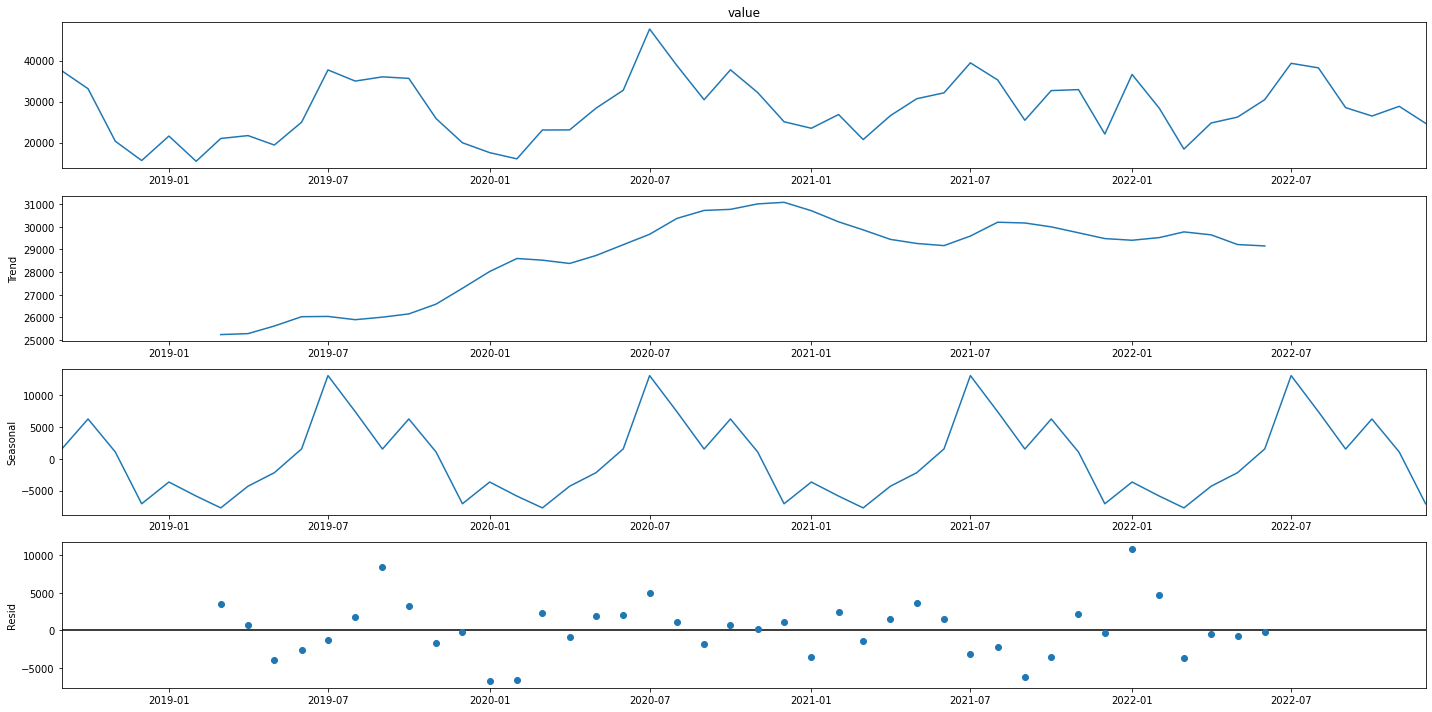

In [255]:
decomposition = sm.tsa.seasonal_decompose(oth['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [155]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(oth['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1195.1019275098702


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:919.5027750357139
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:779.3796741521448


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1212.3328848424035
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:799.9594383418503
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:777.2566325004262
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:560.3257736108268


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1346.2086770566248
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1137.6309272397787
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:920.632128664286
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:757.2786383854127


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:899.9029606444925
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:901.4675567191782
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:858.5073388550621
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:560.811945577178


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1077.762497870288
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1026.4623719058404


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:784.4052342855279
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:769.4398921536049


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1180.9886009484321
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:784.2203120135104
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:760.7596451037911
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:551.6345432293103


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:846.6424377720662
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1004.4152036269778


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:778.4444428522563
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:743.9013270810393


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:964.2979959492549
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:783.6024915288461
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:741.3488689205307
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:543.2871413664782


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:988.0953484831424
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1047.105522915183
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1478.372908749273
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:776.0532623569926


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1199.8718804026446
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:784.8777260443056
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:784.1524341117728
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:540.516075063161


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1221.8720027658874
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1029.0772523357427
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1431.9203557198307
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:758.7582717106349
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1019.434053989881
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:785.9070646220705
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:760.6892394681388
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:542.4563849497995


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1153.0015900695512
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1028.0909108418746


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:786.5659258305179
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:767.1437757044034


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1066.8305603650997
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:767.8242500361085
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:756.1733349778146
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:528.728176002985


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1068.8542013614533
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1002.3041741452145
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:747.0038611724514
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:744.3798770238583
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1137.3222831118483
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:764.1994217447226
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:742.1692586411986
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:525.4610147324781
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1122.3261295231005


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [256]:
mod = sm.tsa.statespace.SARIMAX(oth['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4727      0.259      1.827      0.068      -0.034       0.980
ma.L1         -0.7803      0.201     -3.886      0.000      -1.174      -0.387
ar.S.L12       0.1405      0.141      0.996      0.319      -0.136       0.417
sigma2       2.91e+07   6.39e-10   4.55e+16      0.000    2.91e+07    2.91e+07


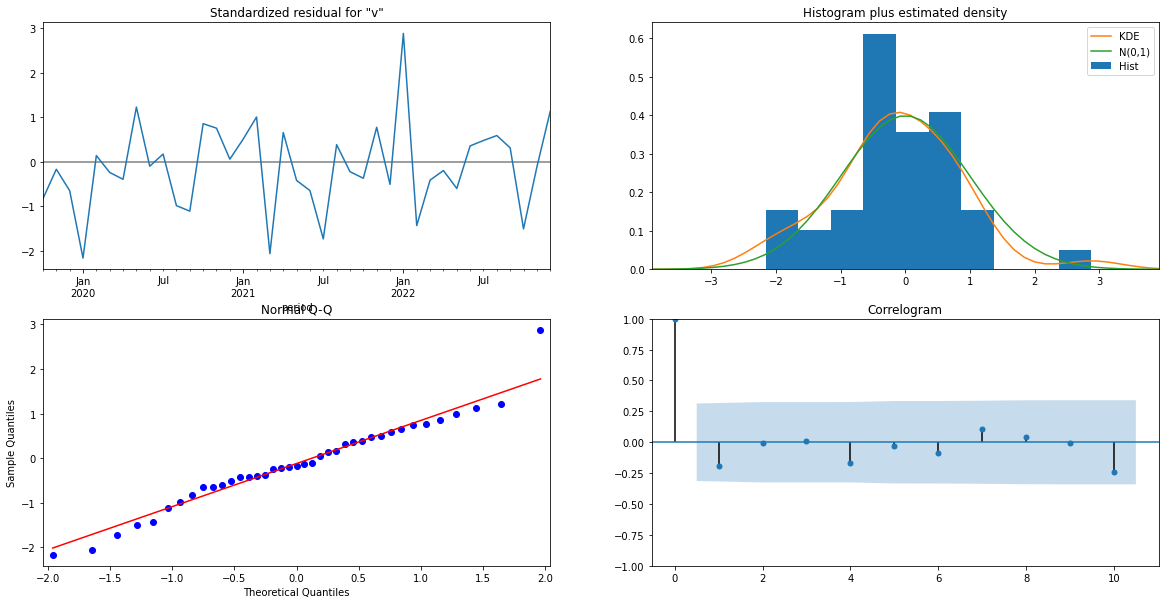

In [257]:
results.plot_diagnostics()
plt.show()

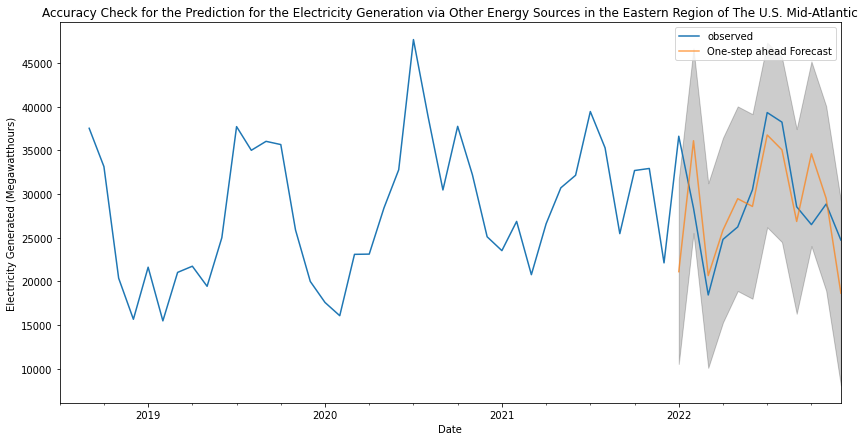

In [258]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = oth['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [259]:
oth_forecasted = pred.predicted_mean
oth_truth = oth['2022-01-01':]
mse = ((oth_forecasted - oth_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36920064.53


In [160]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6076.19


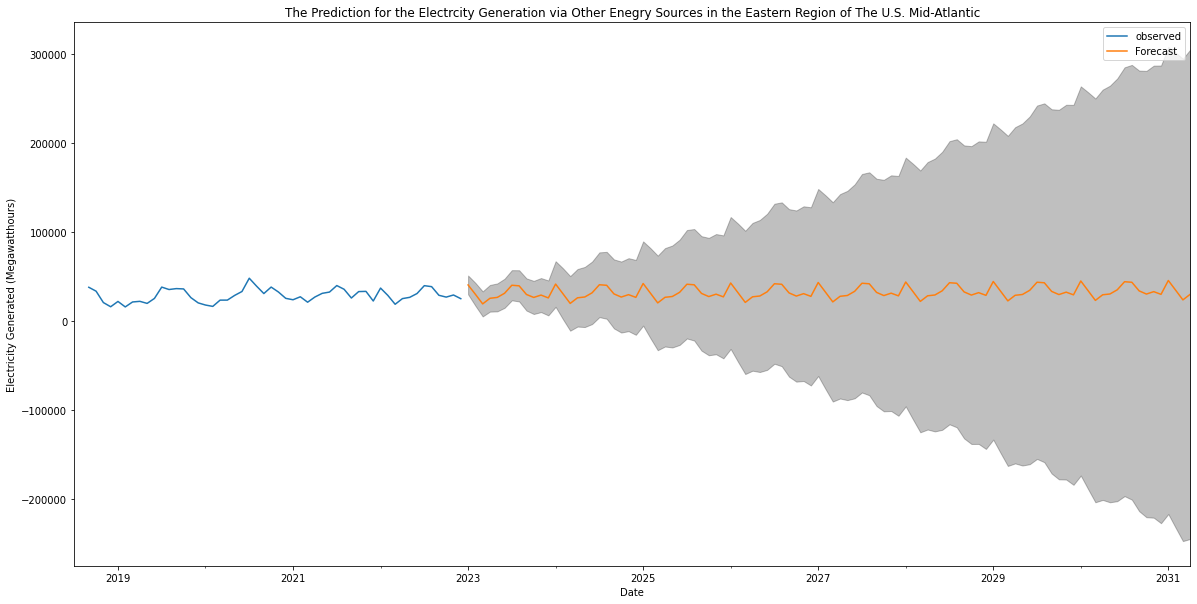

In [260]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = oth.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Other Enegry Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

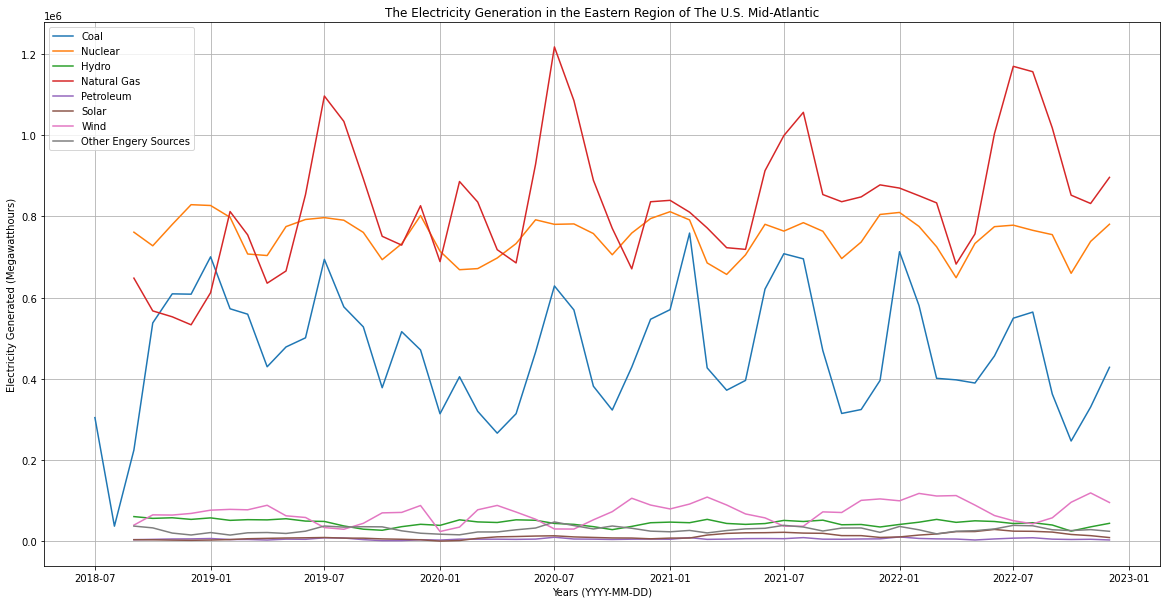

In [261]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(col, label = 'Coal')
plt.plot(nuc, label = 'Nuclear')
plt.plot(wat, label = 'Hydro')
plt.plot(ng, label = 'Natural Gas')
plt.plot(oil, label = 'Petroleum')
plt.plot(sun, label = 'Solar')
plt.plot(wnd, label = 'Wind')
plt.plot(oth, label = 'Other Engery Sources')
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()